# Tutorial 10: Adversarial attacks

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

**Filled notebook:** 
[![View notebooks on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/Adversarial_Attacks.ipynb)  
**Pre-trained models and dataset:** 
[![View files on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/saved_models/tree/main/tutorial10)
[![GoogleDrive](https://img.shields.io/static/v1.svg?logo=google-drive&logoColor=yellow&label=GDrive&message=Download&color=yellow)](https://drive.google.com/drive/folders/1k01P6w31VOW9TT0gTEP9kog315qyiXCd?usp=sharing)  
**Recordings:** 
[![YouTube - Part 1](https://img.shields.io/static/v1.svg?logo=youtube&label=YouTube&message=Part%201&color=red)](https://youtu.be/uidLtkhZFwY)
[![YouTube - Part 2](https://img.shields.io/static/v1.svg?logo=youtube&label=YouTube&message=Part%202&color=red)](https://youtu.be/Dmbz0ffc6Wg)
[![YouTube - Part 3](https://img.shields.io/static/v1.svg?logo=youtube&label=YouTube&message=Part%203&color=red)](https://youtu.be/0dt2Su-SRpI)    
**Author:** Phillip Lippe

In this tutorial, we will discuss adversarial attacks on deep image classification models. As we have seen in many of the previous tutorials so far, Deep Neural Networks are a very powerful tool to recognize patterns in data, and, for example, perform image classification on a human-level. However, we have not tested yet how robust these models actually are. Can we "trick" the model and find failure modes? Can we design images that the networks naturally classify incorrectly? Due to the high classification accuracy on unseen test data, we would expect that this can be difficult. However, in 2014, a research group at Google and NYU showed that deep CNNs can be easily fooled, just by adding some salient but carefully constructed noise to the images. For instance, take a look at the example below (figure credit - [Goodfellow et al.](https://arxiv.org/pdf/1412.6572.pdf)):

<center width="100%" style="padding: 20px"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/adversarial_example.svg?raw=1" width="550px"></center>

The image on the left is the original image from ImageNet, and a deep CNN classifies the image correctly as "panda" with a class likelihood of 57%. Nevertheless, if we add a little noise to every pixel of the image, the prediction of the model changes completely. Instead of a panda, our CNN tells us that the image contains a "gibbon" with the confidence of over 99%. For a human, however, these two images look exactly alike, and you cannot distinguish which one has noise added and which doesn't. While this first seems like a fun game to fool trained networks, it can have a serious impact on the usage of neural networks. More and more deep learning models are used in applications, such as for example autonomous driving. Imagine that someone who gains access to the camera input of the car, could make pedestrians "disappear" for the image understanding network by simply adding some noise to the input as shown below (the figure is taken from [J.H. Metzen et al.](https://openaccess.thecvf.com/content_ICCV_2017/papers/Metzen_Universal_Adversarial_Perturbations_ICCV_2017_paper.pdf)). The first row shows the original image with the semantic segmentation output on the right (pedestrians red), while the second row shows the image with small noise and the corresponding segmentation prediction. The pedestrian becomes invisible for the network, and the car would think the road is clear ahead.

<center width="100%" style="padding: 20px"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial10/adversarial_attacks_cityscapes_3.png?raw=1" width="600px"></center>

Some attack types don't even require to add noise, but minor changes on a stop sign can be already sufficient for the network to recognize it as a "50km/h" speed sign ([paper](https://arxiv.org/pdf/1707.08945.pdf), [paper](https://arxiv.org/pdf/1802.06430.pdf)). The consequences of such attacks can be devastating. Hence, every deep learning engineer who designs models for an application should be aware of the possibility of adversarial attacks.

To understand what makes CNNs vulnerable to such attacks, we will implement our own adversarial attack strategies in this notebook, and try to fool a deep neural network. Let's being with importing our standard libraries:

In [4]:
## Standard libraries
import os
import json
import math
import time
import numpy as np 
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

# from tools
# Move up one directory to import from the tools folder
%cd ..
from tools.resnet20 import ResNetCIFAR
from tools.train_util import *
# Move back to the adversarial patch folder
!pwd
%cd /workspaces/Adversarial_Patch_Attack/adversarial patch

/tmp/ipykernel_3058/796429441.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Global seed set to 42


Using device cuda:0
/workspaces/Adversarial_Patch_Attack
/workspaces/Adversarial_Patch_Attack
/workspaces/Adversarial_Patch_Attack/adversarial patch


We have again a few download statements. This includes both a dataset, and a few pretrained patches we will use later.

In [5]:
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

## Deep CNNs on ImageNet

For our experiments in this notebook, we will use common CNN architectures trained on the ImageNet dataset. Such models are luckily provided by PyTorch's torchvision package, and hence we just need to load the model of our preference. For the results on the website and default on Google Colab, we use a ResNet34. Feel free to experiment with other architectures as well, the code is mainly independent of the specific architecture we choose.

In [6]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = ResNetCIFAR(num_layers=20, Nbits=None)
pretrained_model = pretrained_model.to(device)
pretrained_model.load_state_dict(torch.load("/workspaces/Adversarial_Patch_Attack/tools/pretrained_model_resnet20.pt",map_location=torch.device('cpu')))

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

To perform adversarial attacks, we also need a dataset to work on. Given that the CNN model has been trained on ImageNet, it is only fair to perform the attacks on data from ImageNet. For this, we provide a small set of pre-processed images from the original ImageNet dataset (note that this dataset is shared under the same [license](http://image-net.org/download-faq) as the original ImageNet dataset). Specifically, we have 5 images for each of the 1000 labels of the dataset. We can load the data below, and create a corresponding data loader.

In [7]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
#imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
#assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
#                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
#dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
dataset = torchvision.datasets.CIFAR10(root=DATASET_PATH, train=True, download=True, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=128, shuffle=False, drop_last=False, num_workers=8)

# Get label names of CIFAR10 class
label_names = dataset.classes
print(label_names)

# Get label index of CIFAR10 class
def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


/home/codespace/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
# try get_label_index
get_label_index('cat')

3

Before we start with our attacks, we should verify the performance of our model. As ImageNet has 1000 classes, simply looking at the accuracy is not sufficient to tell the performance of a model. Imagine a model that always predicts the true label as the second-highest class in its softmax output. Although we would say it recognizes the object in the image, it achieves an accuracy of 0. In ImageNet with 1000 classes, there is not always one clear label we can assign an image to. This is why for image classifications over so many classes, a common alternative metric is "Top-5 accuracy", which tells us how many times the true label has been within the 5 most-likely predictions of the model. As models usually perform quite well on those, we report the error (1 - accuracy) instead of the accuracy:

In [11]:
def eval_model(dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels) 
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(2, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-2 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5

In [12]:
_ = eval_model(data_loader)

Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

Top-1 error: 1.29%
Top-2 error: 0.21%


The ResNet34 achives a decent error rate of 4.3% for the top-5 predictions. Next, we can look at some predictions of the model to get more familiar with the dataset. The function below plots an image along with a bar diagram of its predictions. We also prepare it to show adversarial examples for later applications.

In [13]:
pretrained_model = ResNetCIFAR(num_layers=20, Nbits=None)
pretrained_model = pretrained_model.to(device)
pretrained_model.load_state_dict(torch.load("/workspaces/Adversarial_Patch_Attack/tools/pretrained_model_resnet20.pt",map_location=torch.device('cpu')))

<All keys matched successfully>

In [14]:
def show_prediction(img, label, pred, K=2, adv_img=None, noise=None):
    
    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()
    
    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})
    
    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')
    
    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1 
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')
    
    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    print(topk_idx)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')
    
    plt.show()
    plt.close()

Let's visualize a few images below:

tensor([9, 8], device='cuda:0')


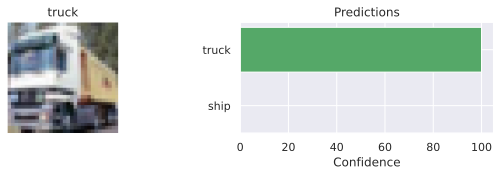

tensor([2, 4], device='cuda:0')


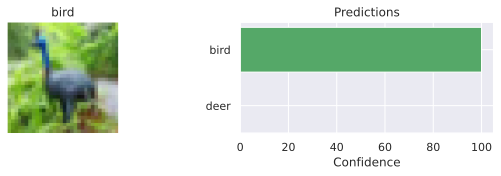

tensor([7, 3], device='cuda:0')


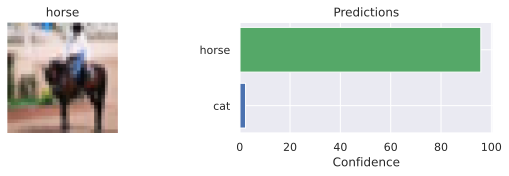

tensor([9, 1], device='cuda:0')


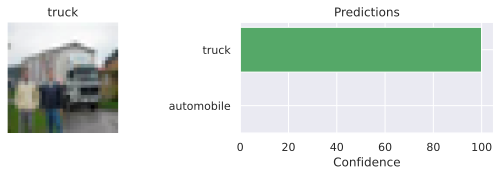

In [15]:
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))

for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

The bar plot on the right shows the top-5 predictions of the model with their class probabilities. We denote the class probabilities with "confidence" as it somewhat resembles how confident the network is that the image is of one specific class. Some of the images have a highly peaked probability distribution, and we would expect the model to be rather robust against noise for those. However, we will see below that this is not always the case. Note that all of the images are of fish because the data loader doesn't shuffle the dataset. Otherwise, we would get different images every time we run the notebook, which would make it hard to discuss the results on the static version.

## White-box adversarial attacks

There have been proposed many possible adversarial attack strategies, which all share the same goal: alternate the data/image input only a little bit to have a great impact on the model's prediction. Specifically, if we look at the ImageNet predictions above, how can we have to change the image of the goldfish so that the model does not recognize the goldfish anymore? At the same time, the label of the image should not change, in the sense that a human would still clearly classify it as a goldfish. This is the same objective that the generator network has in the Generative Adversarial Network framework: try to fool another network (discriminator) by changing its input.

Adversarial attacks are usually grouped into "white-box" and "black-box" attacks. White-box attacks assume that we have access to the model parameter and can, for example, calculate the gradients with respect to the input (similar as in GANs). Black-box attacks on the other hand have the harder task of not having any knowledge about the network, and can only obtain predictions for an image, but no gradients or the like. In this notebook, we will focus on white-box attacks as they are usually easier to implement and follow the intuition of Generative Adversarial Networks (GAN) as studied in lecture 10.

### Fast Gradient Sign Method (FGSM)

One of the first attack strategies proposed is Fast Gradient Sign Method (FGSM), developed by [Ian Goodfellow et al.](https://arxiv.org/pdf/1412.6572.pdf) in 2014. Given an image, we create an adversarial example by the following expression:

$$\tilde{x} = x + \epsilon \cdot \text{sign}(\nabla_x J(\theta,x,y))$$

The term $J(\theta,x,y)$ represents the loss of the network for classifying input image $x$ as label $y$; $\epsilon$ is the intensity of the noise, and $\tilde{x}$ the final adversarial example. The equation resembles SGD and is actually nothing else than that. We change the input image $x$ in the direction of *maximizing* the loss $J(\theta,x,y)$. This is exactly the other way round as during training, where we try to minimize the loss. The sign function and $\epsilon$ can be seen as gradient clipping and learning rate specifically. We only allow our attack to change each pixel value by $\epsilon$. You can also see that the attack can be performed very fast, as it only requires a single forward and backward pass. Let's implement it below:

In [16]:
def fast_gradient_sign_method(model, imgs, labels, epsilon=0.02):
    # Determine prediction of the model
    inp_imgs = imgs.clone().requires_grad_()
    preds = model(inp_imgs.to(device))
    preds = F.log_softmax(preds, dim=-1)
    # Calculate loss by NLL
    loss = -torch.gather(preds, 1, labels.to(device).unsqueeze(dim=-1))
    loss.sum().backward()
    # Update image to adversarial example as written above
    noise_grad = torch.sign(inp_imgs.grad.to(imgs.device))
    fake_imgs = imgs + epsilon * noise_grad
    fake_imgs.detach_()
    return fake_imgs, noise_grad

The default value of $\epsilon=0.02$ corresponds to changing a pixel value by about 1 in the range of 0 to 255, e.g. changing 127 to 128. This difference is marginal and can often not be recognized by humans. Let's try it below on our example images:

tensor([9, 1], device='cuda:0')


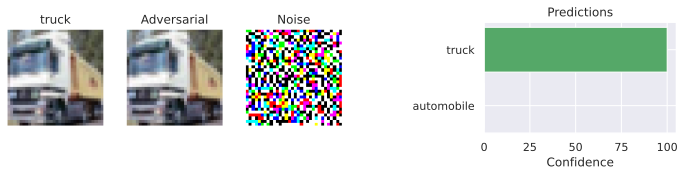

tensor([2, 6], device='cuda:0')


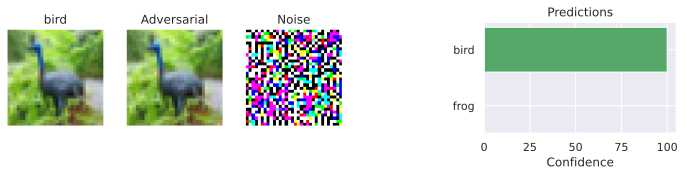

tensor([3, 5], device='cuda:0')


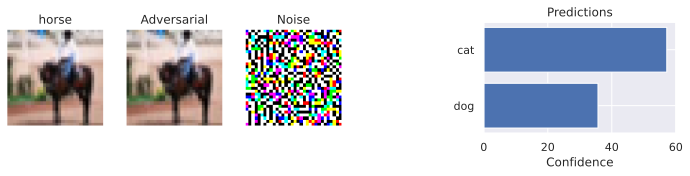

tensor([9, 1], device='cuda:0')


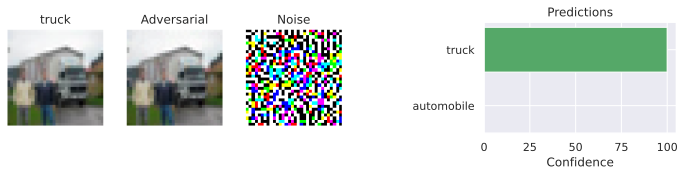

In [17]:
adv_imgs, noise_grad = fast_gradient_sign_method(pretrained_model, exmp_batch, label_batch, epsilon=0.02)
with torch.no_grad():
    adv_preds = pretrained_model(adv_imgs.to(device))
    
for i in range(1,17,5):
    show_prediction(exmp_batch[i], label_batch[i], adv_preds[i], adv_img=adv_imgs[i], noise=noise_grad[i])

Despite the minor amount of noise, we are able to fool the network on all of our examples. None of the labels have made it into the top-5 for the four images, showing that we indeed fooled the model. We can also check the accuracy of the model on the adversarial images:

In [18]:
_ = eval_model(data_loader, img_func=lambda x, y: fast_gradient_sign_method(pretrained_model, x, y, epsilon=0.02)[0])

Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

/home/codespace/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Top-1 error: 28.64%
Top-2 error: 18.85%


As expected, the model is fooled on almost every image at least for the top-1 error, and more than half don't have the true label in their top-5. This is a quite significant difference compared to the error rate of 4.3% on the clean images. However, note that the predictions remain semantically similar. For instance, in the images we visualized above, the tench is still recognized as another fish, as well as the great white shark being a dugong. FGSM could be adapted to increase the probability of a specific class instead of minimizing the probability of a label, but for those, there are usually better attacks such as the adversarial patch.

### Adversarial Patches

Instead of changing every pixel by a little bit, we can also try to change a small part of the image into whatever values we would like. In other words, we will create a small image patch that covers a minor part of the original image but causes the model to confidentially predict a specific class we choose. This form of attack is an even bigger threat in real-world applications than FSGM. Imagine a network in an autonomous car that receives a live image from a camera. Another driver could print out a specific pattern and put it on the back of his/her vehicle to make the autonomous car believe that the car is actually a pedestrian. Meanwhile, humans would not notice it. [Tom Brown et al.](https://arxiv.org/pdf/1712.09665.pdf) proposed a way of learning such adversarial image patches robustly in 2017 and provided a short demonstration on [YouTube](https://youtu.be/i1sp4X57TL4). Interestingly, if you add a small picture of the target class (here *toaster*) to the original image, the model does not pick it up at all. A specifically designed patch, however, which only roughly looks like a toaster, can change the network's prediction instantaneously.

[![Adversarial patch in real world](https://img.youtube.com/vi/i1sp4X57TL4/0.jpg)](https://youtu.be/i1sp4X57TL4)

Let's take a closer look at how we can actually train such patches. The general idea is very similar to FSGM in the sense that we calculate gradients for the input, and update our adversarial input correspondingly. However, there are also some differences in the setup. Firstly, we do not calculate a gradient for every pixel. Instead, we replace parts of the input image with our patch and then calculate the gradients just for our patch. Secondly, we don't just do it for one image, but we want the patch to work with any possible image. Hence, we have a whole training loop where we train the patch using SGD. Lastly, image patches are usually designed to make the model predict a specific class, not just any other arbitrary class except the true label. For instance, we can try to create a patch for the class "toaster" and train the patch so that our pretrained model predicts the class "toaster" for any image with the patch in it.

Additionally, to the setup described above, there are a couple of design choices we can take. For instance, [Brown et al.](https://arxiv.org/pdf/1712.09665.pdf) randomly rotated and scaled the patch during training before placing it at a random position in an input image. This makes the patch more robust to small changes and is necessary if we want to fool a neural network in a real-world application. For simplicity, we will only focus on making the patch robust to the location in the image. Given a batch of input images and a patch, we can add the patch as follows:

In [19]:
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

The patch itself will be an `nn.Parameter` whose values are in the range between $-\infty$ and $\infty$. Images are, however, naturally limited in their range, and thus we write a small function that maps the parameter into the image value range of ImageNet:

In [20]:
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

Before looking at the actual training code, we can write a small evaluation function. We evaluate the success of a patch by how many times we were able to fool the network into predicting our target class. A simple function for this is implemented below.

In [21]:
def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image, and average the performance
            for _ in range(4): 
                patch_img = place_patch(img, patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # In the accuracy calculation, we need to exclude the images that are of our target class
                # as we would not "fool" the model into predicting those
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    acc = tp/counter
    top5 = tp_5/counter
    return acc, top5

Finally, we can look at the training loop. Given a model to fool, a target class to design the patch for, and a size $k$ of the patch in the number of pixels, we first start by creating a parameter of size $3\times k\times k$. These are the only parameters we will train, and the network itself remains untouched. We use a simple SGD optimizer with momentum to minimize the classification loss of the model given the patch in the image. While we first start with a very high loss due to the good initial performance of the network, the loss quickly decreases once we start changing the patch. In the end, the patch will represent patterns that are characteristic of the class. For instance, if we would want the model to predict a "goldfish" in every image, we would expect the pattern to look somewhat like a goldfish. Over the iterations, the model finetunes the pattern and, hopefully, achieves a high fooling accuracy.

In [23]:
# get dataset size 
dataset_size = len(data_loader.dataset)
print(dataset_size)

50000


In [24]:
def patch_attack(model, target_class, patch_size=64, num_epochs=5):
    # Leave a small set of images out to check generalization
    # In most of our experiments, the performance on the hold-out data points
    # was as good as on the training set. Overfitting was little possible due
    # to the small size of the patches.
    # split train_set and val_set by 90% and 10% of dataset_size
    dataset_size = len(data_loader.dataset)
    train_set, val_set = torch.utils.data.random_split(dataset, [int(dataset_size*0.9), int(dataset_size*0.1)])
    #train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)
    
    # Create parameter and optimizer
    if not isinstance(patch_size, tuple):
        patch_size = (patch_size, patch_size)
    patch = nn.Parameter(torch.zeros(3, patch_size[0], patch_size[1]), requires_grad=True)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()
    
    # Training loop
    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        for img, _ in t:
            img = place_patch(img, patch)
            img = img.to(device)
            pred = model(img)
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            loss = loss_module(pred, labels)
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")
    
    # Final validation
    acc, top5 = eval_patch(model, patch, val_loader, target_class)
    
    return patch.data, {"acc": acc.item(), "top5": top5.item()}

To get some experience with what to expect from an adversarial patch attack, we want to train multiple patches for different classes. As the training of a patch can take one or two minutes on a GPU, we have provided a couple of pre-trained patches including their results on the full dataset. The results are saved in a JSON file, which is loaded below.

In [25]:
# Load evaluation results of the pretrained patches
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)
        
# If you train new patches, you can save the results via calling this function
def save_results(patch_dict):
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t 
                                   for t in patch_dict[cname][psize]["results"]] 
                           for psize in patch_dict[cname]} 
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

Additionally, we implement a function to train and evaluate patches for a list of classes and patch sizes. The pretrained patches include the classes *toaster*, *goldfish*, *school bus*, *lipstick*, and *pineapple*. We chose the classes arbitrarily to cover multiple domains (animals, vehicles, fruits, devices, etc.). We trained each class for three different patch sizes: $32\times32$ pixels, $48\times48$ pixels, and $64\times64$ pixels. We can load them in the two cells below.

In [26]:
def get_patches(class_names, patch_sizes):
    result_dict = dict()

    # Loop over all classes and patch sizes
    for name in class_names:
        result_dict[name] = dict()
        for patch_size in patch_sizes:
            c = label_names.index(name)
            file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")
            # Load patch if pretrained file exists, otherwise start training
            if not os.path.isfile(file_name):
                patch, val_results = patch_attack(pretrained_model, target_class=c, patch_size=patch_size, num_epochs=5)
                print(f"Validation results for {name} and {patch_size}:", val_results)
                torch.save(patch, file_name)
            else:
                patch = torch.load(file_name)
            # Load evaluation results if exist, otherwise manually evaluate the patch
            if name in json_results:
                results = json_results[name][str(patch_size)]
            else:
                results = eval_patch(pretrained_model, patch, data_loader, target_class=c)    
            
            # Store results and the patches in a dict for better access
            result_dict[name][patch_size] = {
                "results": results,
                "patch": patch
            }
        
    return result_dict

Feel free to add any additional classes and/or patch sizes.

In [27]:
#class_names = ['toaster', 'goldfish', 'school bus', 'lipstick', 'pineapple']
class_names = label_names
patch_sizes = [3, 5, 7, 16]

patch_dict = get_patches(class_names, patch_sizes)
save_results(patch_dict) # Uncomment if you add new class names and want to save the new results

/home/codespace/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 6, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for airplane and 3: {'acc': 0.05927777662873268, 'top5': 0.5418333411216736}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for airplane and 5: {'acc': 0.24994410574436188, 'top5': 0.810082733631134}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for airplane and 7: {'acc': 0.4546109437942505, 'top5': 0.9259033203125}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for airplane and 16: {'acc': 0.9995549917221069, 'top5': 1.0}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for automobile and 3: {'acc': 0.02354910783469677, 'top5': 0.5116629600524902}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for automobile and 5: {'acc': 0.5025011301040649, 'top5': 0.9145731329917908}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for automobile and 7: {'acc': 0.7757230997085571, 'top5': 0.9829984307289124}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for automobile and 16: {'acc': 1.0, 'top5': 1.0}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for bird and 3: {'acc': 0.056919146329164505, 'top5': 0.6208351850509644}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for bird and 5: {'acc': 0.45287203788757324, 'top5': 0.9331891536712646}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for bird and 7: {'acc': 0.7562723755836487, 'top5': 0.9915434718132019}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for bird and 16: {'acc': 0.999888002872467, 'top5': 1.0}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for cat and 3: {'acc': 0.07687150686979294, 'top5': 0.7446368932723999}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for cat and 5: {'acc': 0.371277779340744, 'top5': 0.9570555686950684}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for cat and 7: {'acc': 0.7197648286819458, 'top5': 0.9931690692901611}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for cat and 16: {'acc': 1.0, 'top5': 1.0}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for deer and 3: {'acc': 0.032482728362083435, 'top5': 0.5210051536560059}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for deer and 5: {'acc': 0.23495781421661377, 'top5': 0.8171070218086243}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for deer and 7: {'acc': 0.7628797888755798, 'top5': 0.9820563793182373}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for deer and 16: {'acc': 1.0, 'top5': 1.0}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for dog and 3: {'acc': 0.03807983919978142, 'top5': 0.5728144645690918}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for dog and 5: {'acc': 0.47154515981674194, 'top5': 0.9443202018737793}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for dog and 7: {'acc': 0.8596188426017761, 'top5': 0.9971578121185303}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for dog and 16: {'acc': 0.9993296265602112, 'top5': 1.0}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for frog and 3: {'acc': 0.0451713390648365, 'top5': 0.5608589053153992}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for frog and 5: {'acc': 0.28748610615730286, 'top5': 0.8829810619354248}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for frog and 7: {'acc': 0.7050586938858032, 'top5': 0.986440122127533}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for frog and 16: {'acc': 0.9999445080757141, 'top5': 1.0}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for horse and 3: {'acc': 0.021260017529129982, 'top5': 0.47740426659584045}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for horse and 5: {'acc': 0.03803380951285362, 'top5': 0.48404136300086975}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for horse and 7: {'acc': 0.36749887466430664, 'top5': 0.8824451565742493}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for horse and 16: {'acc': 0.999722957611084, 'top5': 1.0}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for ship and 3: {'acc': 0.02435723878443241, 'top5': 0.4444068670272827}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for ship and 5: {'acc': 0.1534494161605835, 'top5': 0.6813442707061768}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for ship and 7: {'acc': 0.4423291087150574, 'top5': 0.8863282203674316}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for ship and 16: {'acc': 0.9999444484710693, 'top5': 1.0}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for truck and 3: {'acc': 0.04069509357213974, 'top5': 0.6452920436859131}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for truck and 5: {'acc': 0.2826305329799652, 'top5': 0.9027220010757446}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for truck and 7: {'acc': 0.6661508083343506, 'top5': 0.9831969738006592}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

  0%|          | 0/1406 [00:00<?, ?it/s]

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Validation results for truck and 16: {'acc': 0.9998893737792969, 'top5': 1.0}


Validating...:   0%|          | 0/391 [00:00<?, ?it/s]

Before looking at the quantitative results, we can actually visualize the patches.

In [ ]:
def show_patches():
    fig, ax = plt.subplots(len(patch_sizes), len(class_names), figsize=(len(class_names)*2.2, len(patch_sizes)*2.2))
    for c_idx, cname in enumerate(class_names):
        for p_idx, psize in enumerate(patch_sizes):
            patch = patch_dict[cname][psize]["patch"]
            patch = (torch.tanh(patch) + 1) / 2 # Parameter to pixel values
            patch = patch.cpu().permute(1, 2, 0).numpy()
            patch = np.clip(patch, a_min=0.0, a_max=1.0)
            ax[p_idx][c_idx].imshow(patch)
            ax[p_idx][c_idx].set_title(f"{cname}, size {psize}")
            ax[p_idx][c_idx].axis('off')
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()
show_patches()

: 

: 

We can see a clear difference between patches of different classes and sizes. In the smallest size, $32\times 32$ pixels, some of the patches clearly resemble their class. For instance, the goldfish patch clearly shows a goldfish. The eye and the color are very characteristic of the class. Overall, the patches with $32$ pixels have very strong colors that are typical for their class (yellow school bus, pink lipstick, greenish pineapple). The larger the patch becomes, the more stretched the pattern becomes. For the goldfish, we can still spot regions that might represent eyes and the characteristic orange color, but it is not clearly a single fish anymore. For the pineapple, we might interpret the top part of the image as the leaves of pineapple fruit, but it is more abstract than our small patches. Nevertheless, we can easily spot the alignment of the patch to class, even on the largest scale.

Let's now look at the quantitative results.

In [ ]:
%%html
<!-- Some HTML code to increase font size in the following table -->
<style>
th {font-size: 120%;}
td {font-size: 120%;}
</style>

: 

: 

In [ ]:
patch_dict

: 

: 

In [ ]:
import tabulate
from IPython.display import display, HTML

def show_table(top_1=True):
    i = 0 if top_1 else 1
    table = [[name] + [f'{(100.0 * patch_dict[name][psize]["results"][i]):4.2f}%' for psize in patch_sizes] for name in class_names]
    display(HTML(tabulate.tabulate(table, tablefmt='html', headers=["Class name"] + [f"Patch size {psize}x{psize}" for psize in patch_sizes])))

: 

: 

First, we will create a table of top-1 accuracy, meaning that how many images have been classified with the target class as highest prediction?

In [ ]:
show_table(top_1=True)

: 

: 

The clear trend, that we would also have expected, is that the larger the patch, the easier it is to fool the model. For the largest patch size of $64\times 64$, we are able to fool the model on almost all images, despite the patch covering only 8% of the image. The smallest patch actually covers 2% of the image, which is almost neglectable. Still, the fooling accuracy is quite remarkable. A large variation can be however seen across classes. While *school bus* and *pineapple* seem to be classes that were easily predicted, *toaster* and *lipstick* seem to be much harder for creating a patch. It is hard to intuitively explain why our patches underperform on those classes. Nonetheless, a fooling accuracy of >40% is still very good for such a tiny patch.

Let's also take a look at the top-5 accuracy:

In [ ]:
show_table(top_1=False)

: 

: 

We see a very similar pattern across classes and patch sizes. The patch size $64$ obtains >99.7% top-5 accuracy for any class, showing that we can almost fool the network on any image. A top-5 accuracy of >70% for the hard classes and small patches is still impressive and shows how vulnerable deep CNNs are to such attacks.

Finally, let's create some example visualizations of the patch attack in action.

In [ ]:
def perform_patch_attack(patch):
    patch_batch = exmp_batch.clone()
    patch_batch = place_patch(patch_batch, patch)
    with torch.no_grad():
        patch_preds = pretrained_model(patch_batch.to(device))
    for i in range(1,17,5):
        show_prediction(patch_batch[i], label_batch[i], patch_preds[i])

: 

: 

In [ ]:
perform_patch_attack(patch_dict['goldfish'][32]['patch'])

: 

: 

The tiny goldfish patch can change all of the predictions to "goldfish" as top class. Note that the patch attacks work especially well if the input image is semantically similar to the target class (e.g. a fish and the target class "goldfish" works better than an airplane image with that patch). Nevertheless, we can also let the network predict semantically dis-similar classes by using a larger patch:

In [ ]:
perform_patch_attack(patch_dict['school bus'][64]['patch'])

: 

: 

Although none of the images have anything to do with an American school bus, the high confidence of often 100% shows how powerful such attacks can be. With a few lines of code and access to the model, we were able to generate patches that we add to any image to make the model predict any class we want. 

### Transferability of white-box attacks

FGSM and the adversarial patch attack were both focused on one specific image. However, can we transfer those attacks to other models? The adversarial patch attack as proposed in [Brown et al.](https://arxiv.org/pdf/1712.09665.pdf), was originally trained on multiple models, and hence was also able to work on many different network architecture. But how different are the patches for different models anyway? For instance, let's evaluate some of our patches trained above on a different network, e.g. DenseNet121.

In [ ]:
transfer_model = torchvision.models.densenet121(weights='IMAGENET1K_V1')
transfer_model = transfer_model.to(device)

# No gradients needed for the network
transfer_model.eval()
for p in transfer_model.parameters():
    p.requires_grad = False

: 

: 

Feel free to change the class name and/or patch size below to test out different patches.

In [ ]:
class_name = 'pineapple'
patch_size = 64
print(f"Testing patch \"{class_name}\" of size {patch_size}x{patch_size}")

results = eval_patch(transfer_model, 
                     patch_dict[class_name][patch_size]["patch"], 
                     data_loader, 
                     target_class=label_names.index(class_name))

print(f"Top-1 fool accuracy: {(results[0] * 100.0):4.2f}%")
print(f"Top-5 fool accuracy: {(results[1] * 100.0):4.2f}%")

: 

: 

Although the fool accuracy is significantly lower than on the original ResNet34, it still has a considerable impact on DenseNet although the networks have completely different architectures and weights. If you would compare more patches and models, some would work better than others. However, one aspect which allows patch attacks to generalize well is if all the networks have been trained on the same data. In this case, all networks have been trained on ImageNet. Dataset biases make the networks recognize specific patterns in the underlying image data that humans would not have seen, and/or only work for the given dataset. This is why the knowledge of what data has been used to train a specific model is already worth a lot in the context of adversarial attacks.

## Protecting against adversarial attacks

There are many more attack strategies than just FGSM and adversarial patches that we haven't discussed and implemented ourselves here. However, what about the other perspective? What can we do to *protect* a network against adversarial attacks? The sad truth to this is: not much.

White-box attacks require access to the model and its gradient calculation. The easiest way of preventing this is by ensuring safe, private storage of the model and its weights. However, some attacks, called black-box attacks, also work without access to the model's parameters, or white-box attacks can also generalize as we have seen above on our short test on transferability. 

So, how could we eventually protect a model? An intuitive approach would to train/finetune a model on such adversarial images, leading to an adversarial training similar to a GAN. During training, we would pretend to be the attacker, and use for example FGSM as an augmentation strategy. However, this usually just ends up in an oscillation of the defending network between weak spots. Another common trick to increase robustness against adversarial attacks is defensive distillation ([Papernot et al.](https://arxiv.org/pdf/1511.04508.pdf)). Instead of training the model on the dataset labels, we train a secondary model on the softmax predictions of the first one. This way, the loss surface is "smoothed" in the directions an attacker might try to exploit, and it becomes more difficult for the attacker to find adversarial examples. Nevertheless, there hasn't been found the one, true strategy that works against all possible adversarial attacks.

Why are CNNs, or neural networks in general, so vulnerable to adversarial attacks? While there are many possible explanations, the most intuitive is that neural networks don't know what they don't know. Even a large dataset represents just a few sparse points in the extremely large space of possible images. A lot of the input space has not been seen by the network during training, and hence, we cannot guarantee that the prediction for those images is any useful. The network instead learns a very good classification on a smaller region, often referred to as manifold, while ignoring the points outside of it. NNs with uncertainty prediction could potentially help to discover what the network does not know. 
Another possible explanation lies in the activation function. As we know, most CNNs use ReLU-based activation functions. While those have enabled great success in training deep neural networks due to their stable gradient for positive values, they also constitute a possible flaw. The output range of a ReLU neuron can be arbitrarily high. Thus, if we design a patch or the noise in the image to cause a very high value for a single neuron, it can overpower many other features in the network. Thus, although ReLU stabilizes training, it also offers a potential point of attack for adversaries.

## Conclusion

In this tutorial, we have looked at different forms of adversarial attacks. Deep CNNs can be fooled by only slight modifications to the input. Whether it is a carefully designed noise pattern, unnoticeable for a human, or a small patch, we are able to manipulate the networks' predictions significantly. The fact that even white-box attacks can be transferable across networks, and that there exist no suitable protections against all possible adversarial attacks, make this concept a massive problem for real-world applications. While adversarial attacks can also be used for improving/training a robust model or a GAN, it is not close to being solved yet. This is also because neural networks are currently complex, unknown non-linear functions in high-dimensional looking for correlations instead of causation. In the next years, we might hopefully see an improvement in the stability of such models by using causal approaches and/or introducing uncertainty. 

## References

[1] Goodfellow, Ian J., Jonathon Shlens, and Christian Szegedy. "Explaining and harnessing adversarial examples." ICLR 2015.

[2] Hendrik Metzen, Jan, et al. "Universal adversarial perturbations against semantic image segmentation." Proceedings of the IEEE International Conference on Computer Vision. 2017.

[3] Anant Jain. "Breaking neural networks with adversarial attacks." [Blog post](https://towardsdatascience.com/breaking-neural-networks-with-adversarial-attacks-f4290a9a45aa) 2019.

---

[![Star our repository](https://img.shields.io/static/v1.svg?logo=star&label=⭐&message=Star%20Our%20Repository&color=yellow)](https://github.com/phlippe/uvadlc_notebooks/)  If you found this tutorial helpful, consider ⭐-ing our repository.    
[![Ask questions](https://img.shields.io/static/v1.svg?logo=star&label=❔&message=Ask%20Questions&color=9cf)](https://github.com/phlippe/uvadlc_notebooks/issues)  For any questions, typos, or bugs that you found, please raise an issue on GitHub. 

---